# State-of-the-art for word-level intrinsic eval
Bruni, Tran, Baroni (multimodal dist semantics):
 - ws: 0.7
 - men: 0.77
TODO Need to find more recent papers

RG: http://aclweb.org/aclwiki/index.php?title=RG-65_Test_Collection_(State_of_the_art)
$\rho=0.89$

# Test: instrinsic eval on noise-corrupted vectors

Add noise as usual, evaluate intrinsically.

### Coverage
Vectors trained on less data will have lower coverage of types, so they may not be able to provide and answer for all word pairs in the test sets. I handle this in two ways:
 - relaxed: OOV items are not looked at. This may provide an unfair advantage to vectors trained on less data, because we forgive their poor coverage
 - strict: OOV items score 0 correlation.
 
### PoS tags
Words in 3/4 datasets are provided without PoS tags (only MEN provides tags). In my work `cat/J`, `cat/N` and `cat/V` have different vectors, so before evaluation I need to map `cat` to one of these two versions. I use the first PoS tag that is found, in the order `JNV`. I could have ignored words in the test set that may map to multiple PoS tags.
 
 
### Questions
 - Do people use the strict version?
 - What do I do with multiple possible POS tags per word for `ws353` data?

# Running experiment
Run `thesisgenerator/scripts/intrinsic_eval_words.py` first and make sure results are in the right place.

In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *

sns.timeseries.algo.bootstrap = my_bootstrap
sns.categorical.bootstrap = my_bootstrap

/Users/miroslavbatchkarov/NetBeansProjects/ExpLosion


In [4]:
noise_df = pd.read_csv('../thesisgenerator/intrinsic_noise_word_level.csv', index_col=0)
noise_df['Dataset'] = noise_df.test.map(str.upper)
noise_df = noise_df.drop('test', axis=1)
noise_df.vect = noise_df.vect.map({'w2v-giga-100':'Gigaw', 'w2v-wiki-15':'Wiki'})
noise_df.head()

,vect,noise,kind,corr,pval,folds,Dataset
0,Gigaw,0,strict,0.463833,3.120347e-20,0,WS353
1,Gigaw,0,relaxed,0.553462,1.340141e-28,0,WS353
2,Gigaw,0,strict,0.466006,1.975560e-20,1,WS353
3,Gigaw,0,relaxed,0.533901,2.252053e-26,1,WS353
4,Gigaw,0,strict,0.382868,9.066415e-14,2,WS353


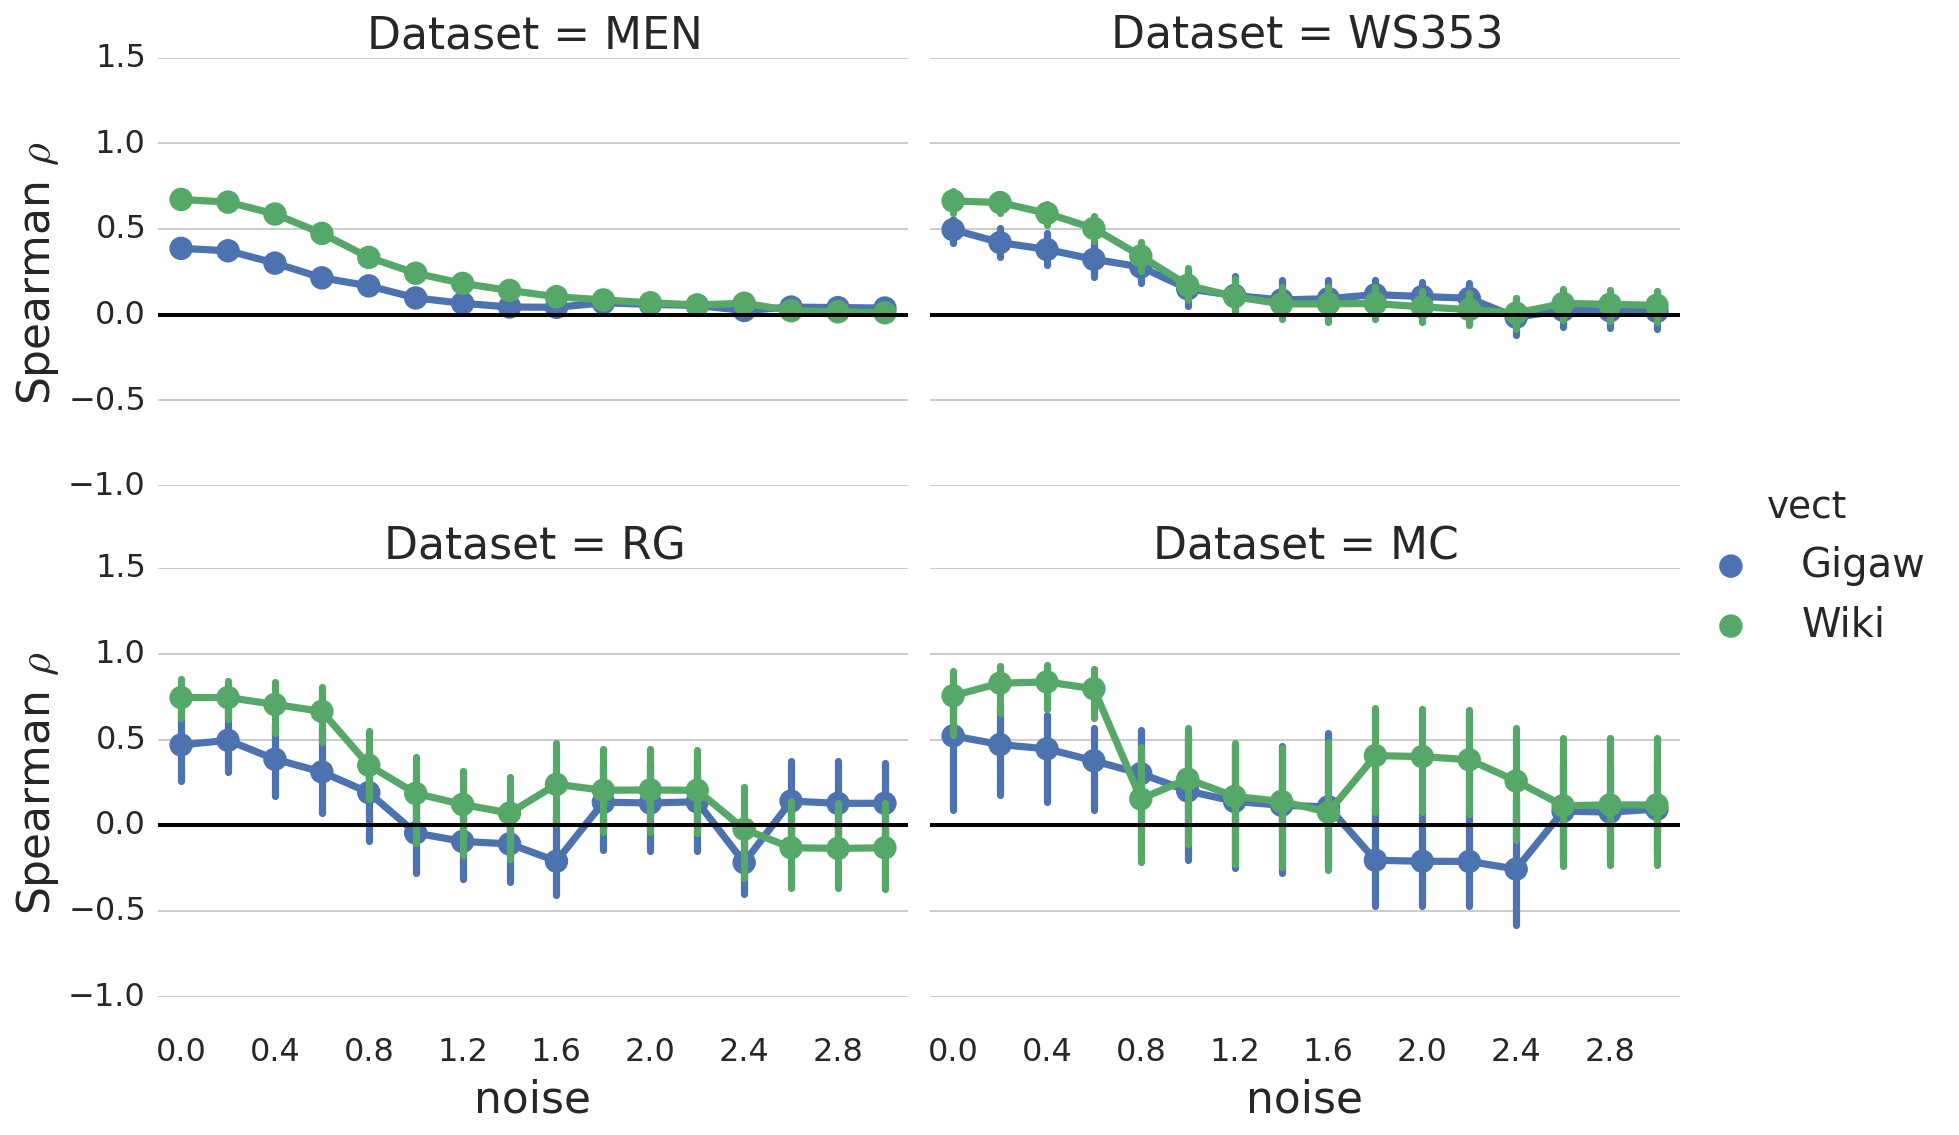

In [5]:
with sns.axes_style('whitegrid'):
    g = sns.factorplot(x='noise', hue='vect', col='Dataset', y='corr', col_wrap=2,
                       data=noise_df[noise_df.kind == 'strict'], kind='point', 
                       x_order=sorted(noise_df.noise.unique()), aspect=1.5,
                      col_order = ['MEN', 'WS353', 'RG', 'MC']
                      );
g.set_ylabels('Spearman $\\rho$')
sns.despine(left=True, bottom=True)
for ax in g.axes.flat:
    sparsify_axis_labels(ax)
    ax.axhline(0, c='k')

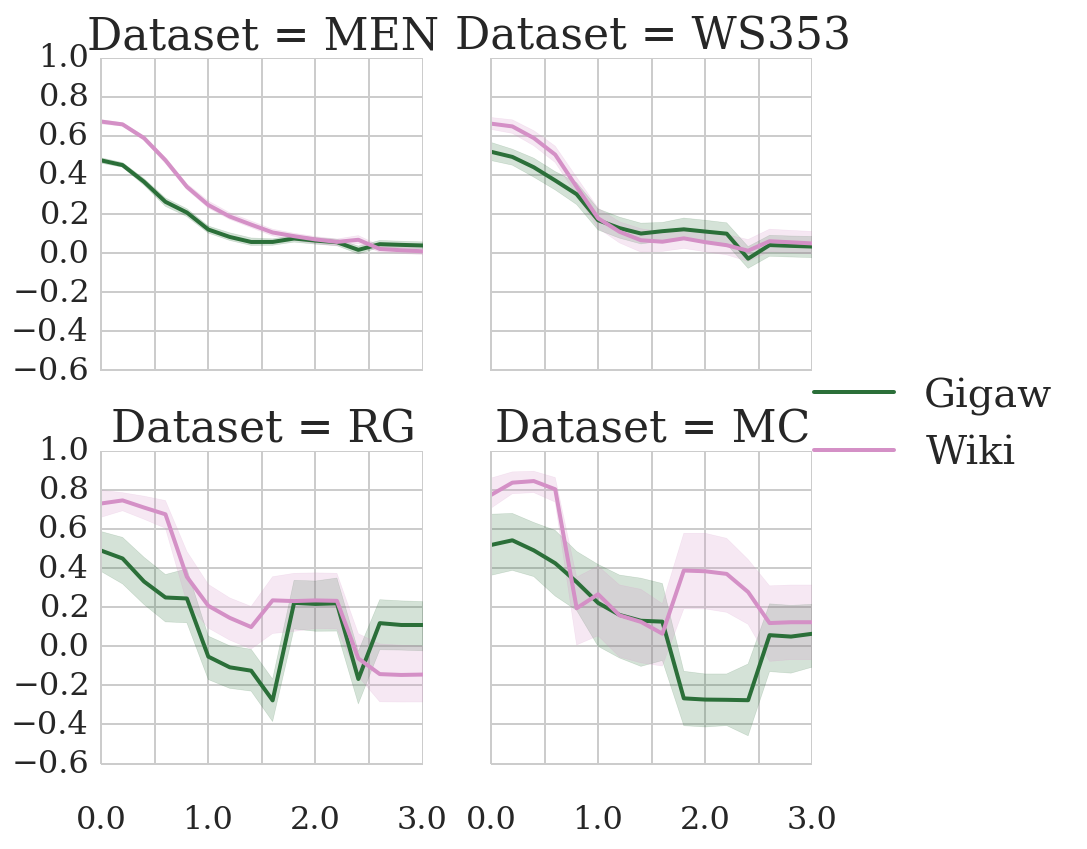

In [9]:
g = sns.FacetGrid(noise_df[noise_df.kind == 'relaxed'], col='Dataset', col_wrap=2,
                 col_order = ['MEN', 'WS353', 'RG', 'MC'])
with sns.color_palette("cubehelix", 2):
    g.map_dataframe(tsplot_for_facetgrid, time='noise', value='corr', condition='vect', 
                    unit='folds', ci=68).add_legend()
for ax in g.axes.flat:
    sparsify_axis_labels(ax)
plt.savefig('plot-intrinsic-noise.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

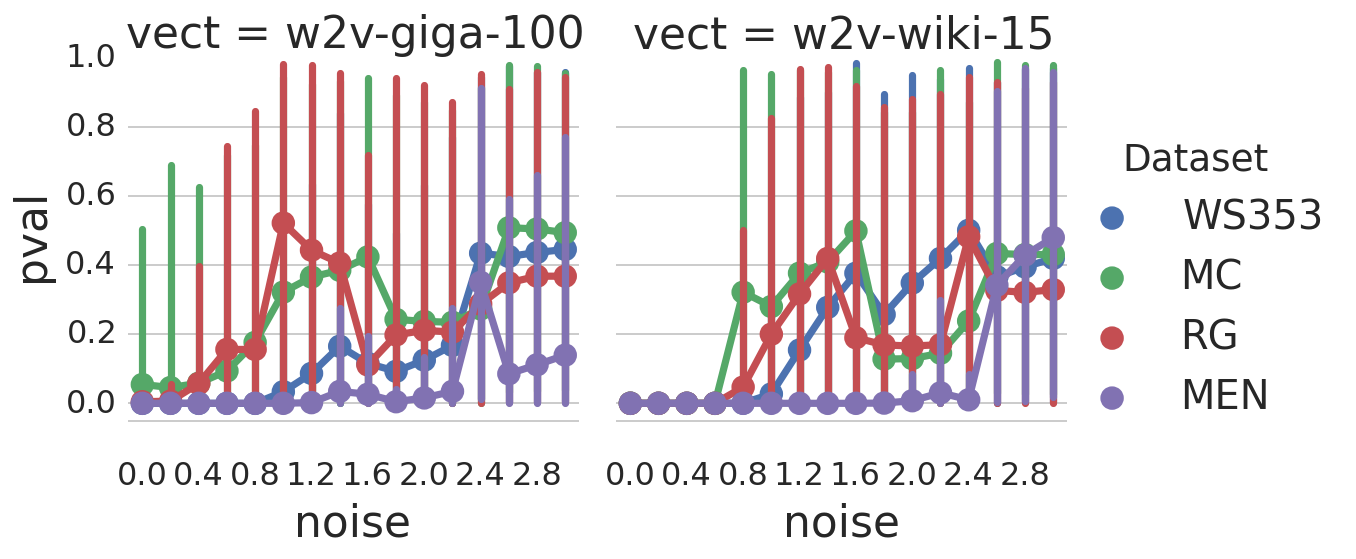

In [13]:
with sns.axes_style('whitegrid'):
    g = sns.factorplot(x='noise', col='vect', hue='Dataset', y='pval',
                   data=noise_df[noise_df.kind == 'relaxed'], 
                   kind='point', 
                   x_order=sorted(noise_df.noise.unique()));
sns.despine(left=True)
for ax in g.axes.flat:
    sparsify_axis_labels(ax)
    ax.set_ylim(-0.05, 1)

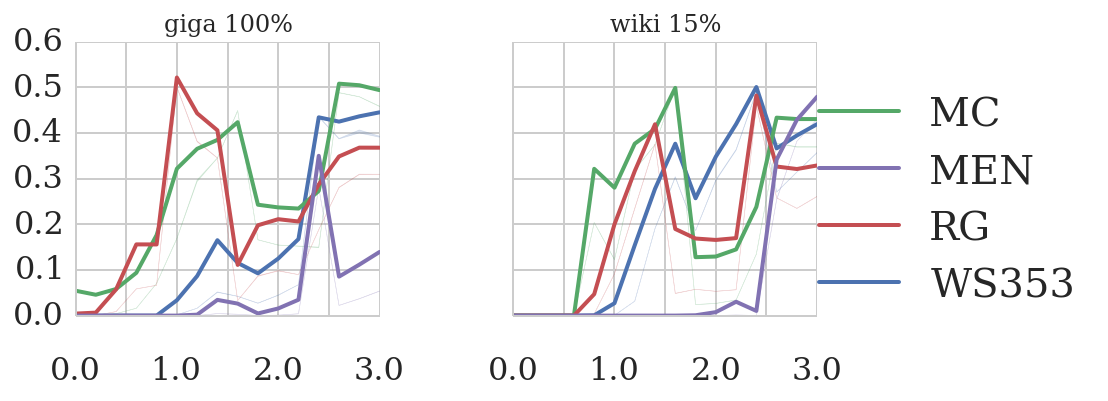

In [14]:
g = sns.FacetGrid(noise_df[noise_df.kind == 'relaxed'], col='vect')
g.map_dataframe(tsplot_for_facetgrid, time='noise', value='pval',
                condition='Dataset', unit='folds', ci=0.1).add_legend()
for ax in g.axes.flat:
    sparsify_axis_labels(ax)
    ax.set_title('{1} {2}%'.format(*ax.title._text.split('-')))


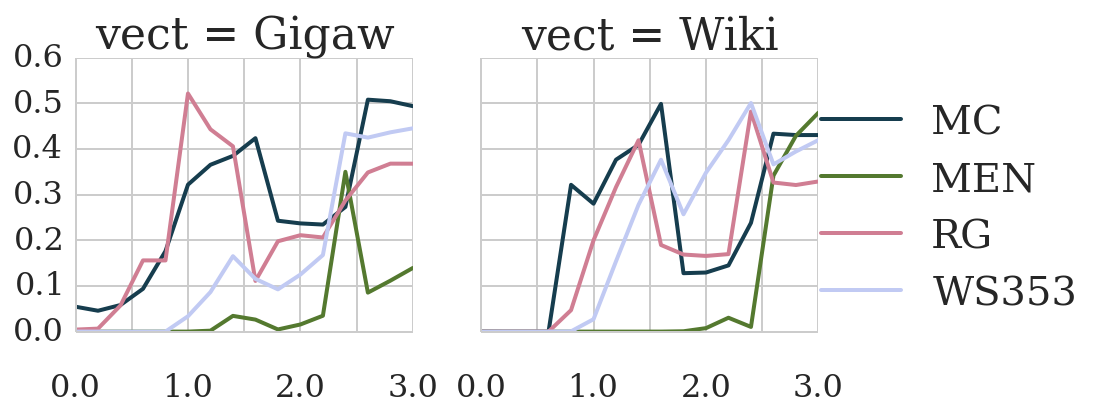

In [8]:
# version of the above without percentiles
noise_df2 = noise_df[noise_df.kind == 'relaxed'].groupby(['Dataset', 'vect', 'noise']).mean().reset_index()
with sns.color_palette("cubehelix", 4):
    g = sns.FacetGrid(noise_df2, col='vect')
    g.map_dataframe(tsplot_for_facetgrid, time='noise', value='pval',
                    condition='Dataset', unit='folds', ci=0.1).add_legend()

for ax in g.axes.flat:
    sparsify_axis_labels(ax)
#     ax.set_title('{1} {2}%'.format(*ax.title._text.split('-')),
#                 fontsize=18)
plt.savefig('plot-intrinsic-pvals.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)



 
# Observations
 - Measured vector quality decreases nicely for WS353/MEN, oscilates for MC/RG.
 - P-value of correlation for smallers datasets explodes early, i.e. chance of such a strong correlation being observed by chance. Test has low power

# Test: Learning curve

Evaluate vectors intrinsically as more unlabelled training data is added 

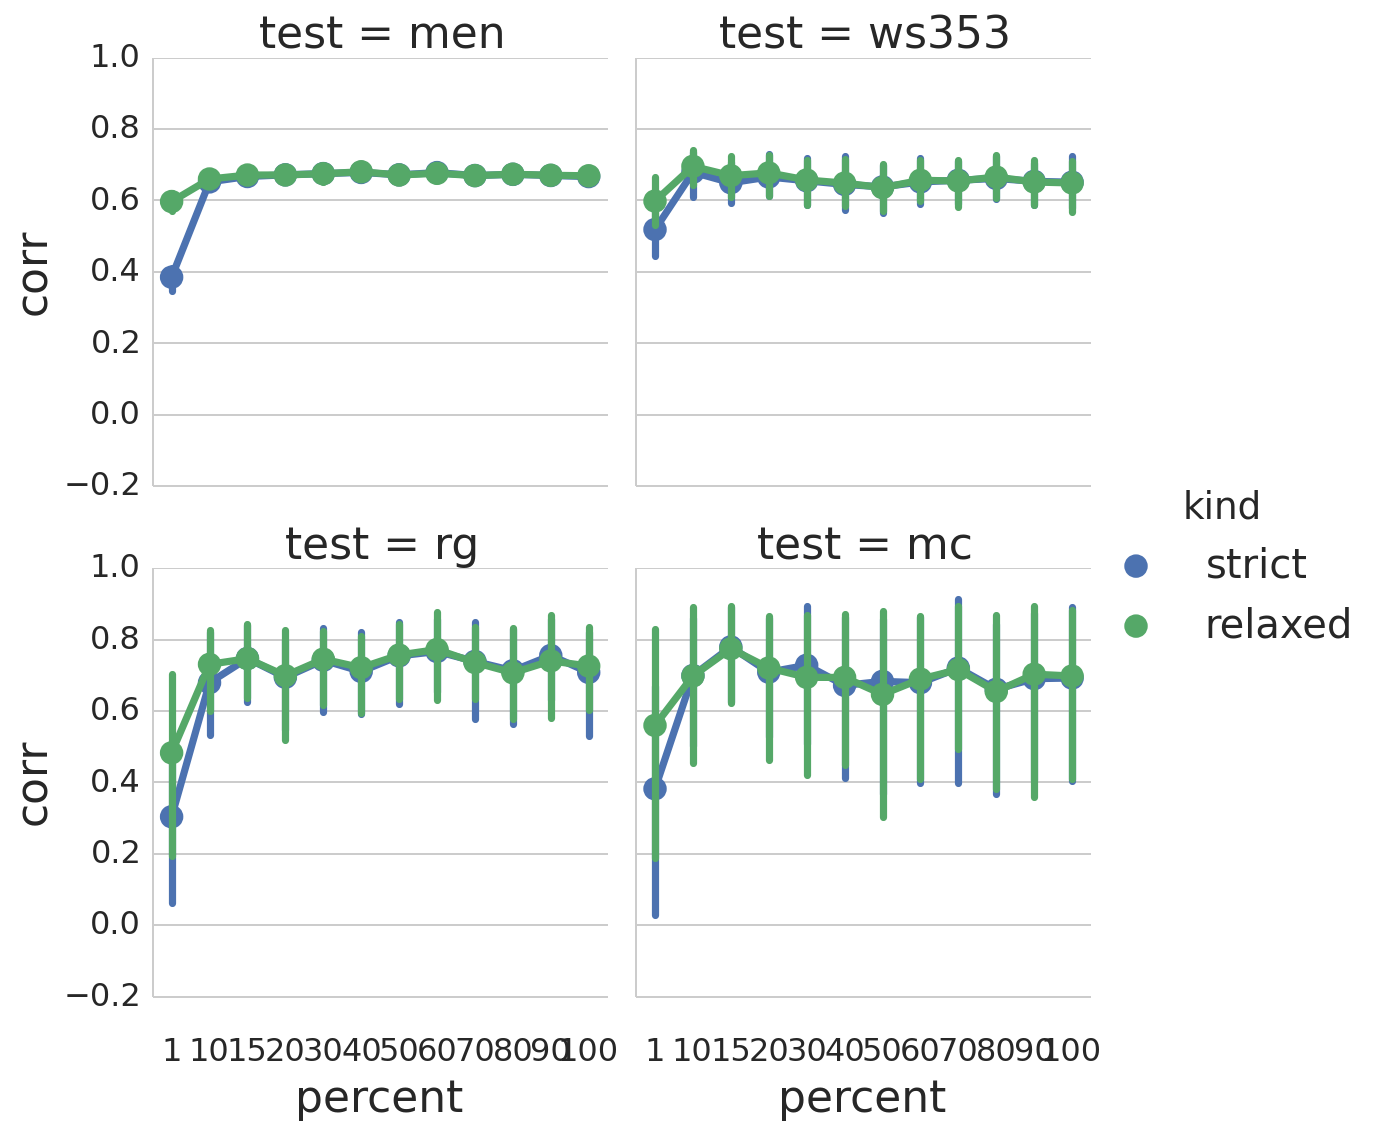

In [7]:
curve_df = pd.read_csv('../thesisgenerator/intrinsic_learning_curve_word_level.csv')
with sns.axes_style('whitegrid'):
    sns.factorplot(data=curve_df, col='test', x='percent', y='corr', 
                   hue='kind', col_wrap=2, col_order = ['men', 'ws353', 'rg', 'mc'])

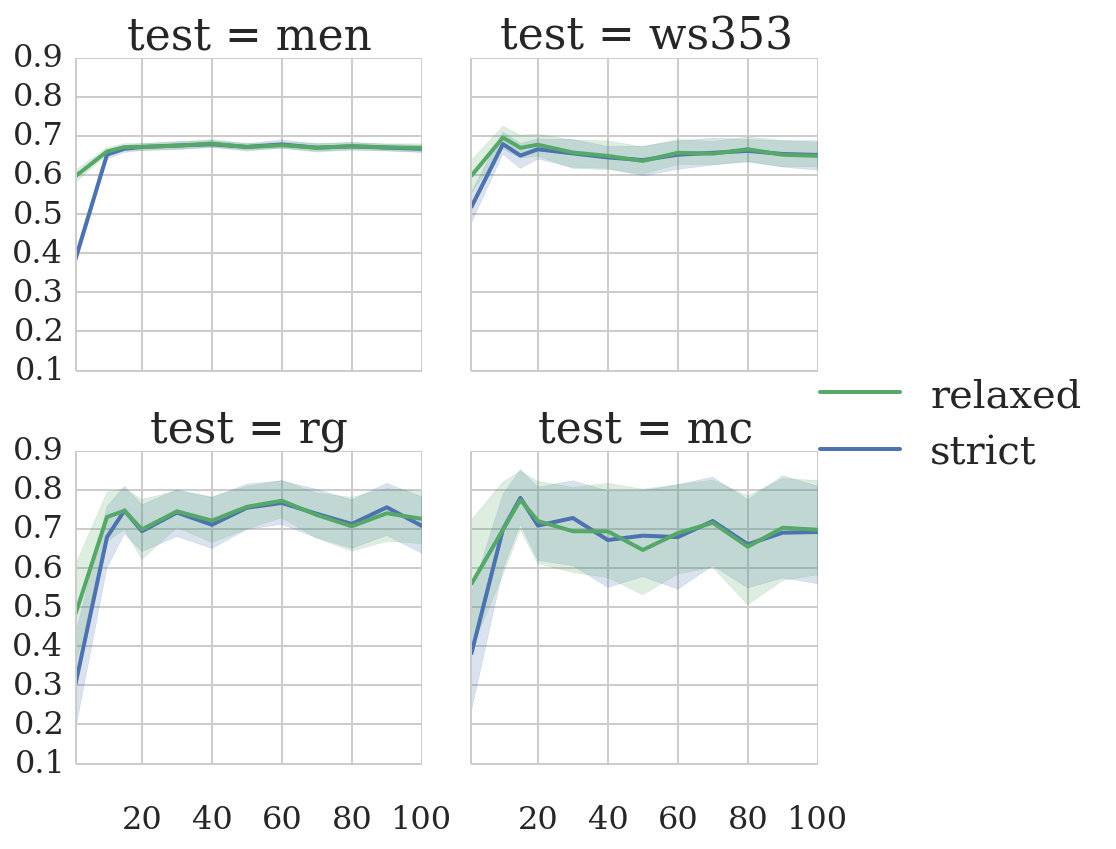

In [8]:
g = sns.FacetGrid(curve_df, col='test', col_wrap=2,
                 col_order = ['men', 'ws353', 'rg', 'mc'])
g.map_dataframe(tsplot_for_facetgrid, time='percent', value='corr', condition='kind', 
                unit='folds', ci=68).add_legend();
plt.savefig('plot-intrinsic-learning-curve.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Observation

None of the intrinsic tests but can tell between `wiki-15` and `wiki-100`, regardless of dataset size. 

I thought this may be because I was using the relaxed score, but the difference between relaxed and strict is generally small. Such a difference only arises when a model's coverage of the test words is poor, i.e. when unlabelled data is very limited. This isn't a real issue (see below)

# Coverage
Almost perfect after 10% of wikipedia

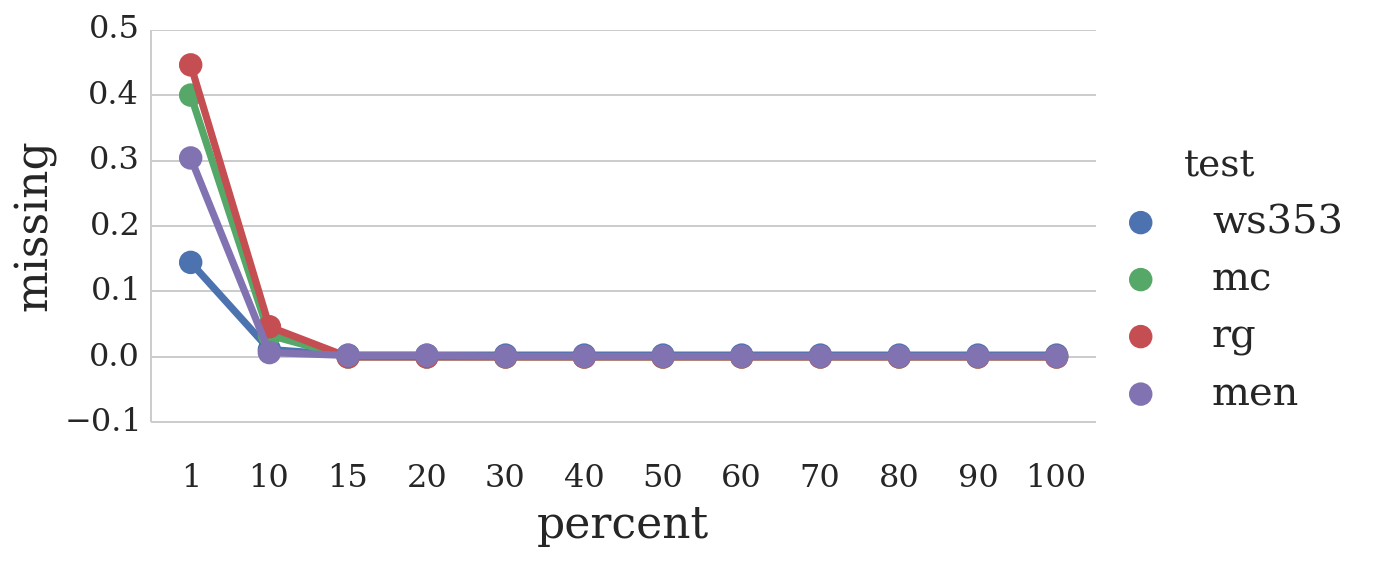

In [9]:
g = sns.factorplot(y='missing', x='percent', hue='test', data=curve_df, aspect=2);

# Repeated runs of `w2v` and multivector boosting 

In [10]:
rep_df = pd.read_csv('../thesisgenerator/intrinsic_w2v_repeats_word_level.csv')

OSError: File b'../thesisgenerator/intrinsic_w2v_repeats_word_level.csv' does not exist

In [13]:
rep_df.head()

,Unnamed: 0,rep_id,test,missing,kind,corr,pval,folds
0,0,0,ws353,0.005666,strict,0.650090,8.938486e-44,0
1,1,0,ws353,0.005666,relaxed,0.576855,1.598804e-32,0
2,2,0,ws353,0.005666,strict,0.646308,3.964640e-43,1
3,3,0,ws353,0.005666,relaxed,0.710423,3.402731e-55,1
4,4,0,ws353,0.005666,strict,0.626497,6.961930e-40,2


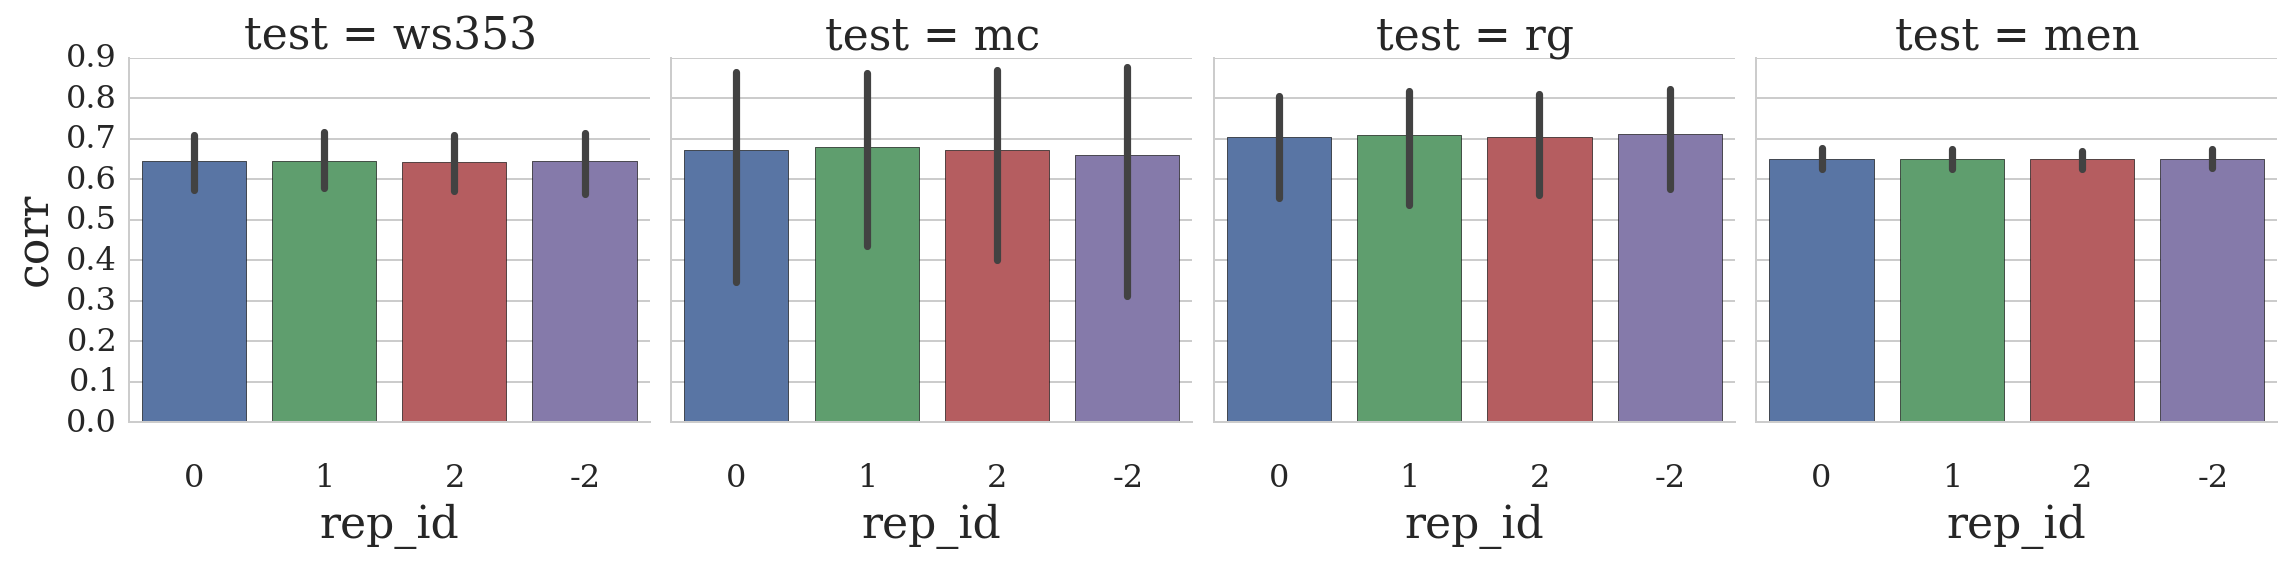

In [14]:
sns.factorplot(data=rep_df, x='rep_id', y='corr', col='test', kind='bar')

In [15]:
from discoutils.thesaurus_loader import Vectors as V
from thesisgenerator.plugins.multivectors import MultiVectors
prefix = 'lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/'
pattern = os.path.join(prefix, 'word2vec-wiki-15perc.unigr.strings.rep%d')
rep_vectors = [V.from_tsv(pattern % i) for i in [0, 1, 2]]
avg_vectors = [V.from_tsv(os.path.join(prefix, 'word2vec-wiki-15perc.unigr.strings.avg3'))]
mv = [MultiVectors(tuple(rep_vectors))]

OSError: File does not exist: /Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-15perc.unigr.strings.rep0

In [ ]:
mv[0].get_nearest_neighbours('love/N')